# Semantic Extraction from Smart Plug Power Consumption Data

스마트 플러그로 측정된 전력 데이터로부터 의미론적 정보 추출하기

## 1. Environmental Setup

In [2]:
import os
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import time

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

In [22]:
def parse_arguments():
    parser = argparse.ArgumentParser(description="Semantic Extraction")
    
    # environment
    parser.add_argument('--debug', action='store_true', help='Enable debug mode')
    parser.add_argument('--data_dir_path', type=str, default=r'C:\smartthings_data\csv_data\20241128', help='Path to data directory')
    parser.add_argument('--save_path', type=str, default=r'C:\Users\lime9\PycharmProjects\semanticProject', help='Path to save')
    parser.add_argument('--save_vis_path', type=str, default=r'C:\Users\lime9\PycharmProjects\semanticProject\visualization', help='Path to save visualization')
    
    # model
    parser.add_argument('--batch_size', type=int, default=50, help='minibatch size')
    parser.add_argument('--num_epochs', type=int, default=50, help='number of epochs')
    parser.add_argument('--learning_rate', type=float, default=0.002, help='learning rate')
    
    return parser.parse_args(args=[]) # if Jupyter Notebook
    # return parser.parse_args()

In [23]:
def main():
    args = parse_arguments()
    data_dir = args.data_dir_path
    save_path = args.save_path
    save_vis = args.save_vis_path
    
    # if not os.path.exists(save_path):
    
    if args.debug:
        print('Running in debug mode...')
    else: 
        print('Running in normal mode...')

In [24]:
if __name__ == '__main__':
    main()

Running in normal mode...


## 2. Load Data
- 스마트 플러그로 측정된 데이터 불러오기
- 측정 날짜 및 시간: 2024/11/28 15:15-16:30 (1h 15m)
- 측정 센서: SMP01 - SMP15
- 자세한 측정 장비에 대해서는 notion 참고

In [1]:
# mapping relationships
appliances_mapping = {
    "SMP01": "Refrigerator(207)",
    "SMP02": "Projector",
    "SMP03": "Haewon Computer",
    "SMP04": "Jeein Monitor",
    "SMP05": "Jeein Computer",
    "Door01": "Door",
    "Motion01": "Motion",
    "Camera01": "Camera",
    "Vacuum01": "Vacuum",
    "SMP06": "Refrigerator(205)",
    "SMP07": "NA",
    "SMP08": "Air Purifier",
    "SMP09": "Yurim Computer(205)",
    "SMP10": "Jaewon Computer",
    "SMP11": "NA",
    "SMP12": "Yurim Monitor",
    "SMP13": "Printer(207)",
    "SMP14": "Haewon Monitor",
    "SMP15": "Giup Computer",
    "SMP16": "Jeein Lamp",
    "SMP17": "Haewon Lamp",
    "SMP18": "Yurim Lamp",
    "SMP19": "Yurim Computer(207)",
    "SMP20": "Laptop Charger(Projector)",
}

In [3]:
def load_data(data_dir_path):
    # Load the data
    files = [file for file in os.listdir(data_dir_path) if file.endswith('.csv')]
    dfs = []
    for file in files:
        data_file_path = os.path.join(data_dir_path, file)
        df = pd.read_csv(data_file_path)
        device_id = file.split('_')[0]
        df['Appliance'] = appliances_mapping.get(device_id, "Unknown")
        dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Prepare the dataframe
    combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'])
    
    return combined_df

In [18]:
data_dir = r'C:\smartthings_data\csv_data\20241128'
df = load_data(data_dir)

In [5]:
df.head()

,Timestamp,Label,Location Name,Power (W),Energy (Wh),Appliance
0,2024-11-28 13:45:17,SMP01,Laboratory 207,31.258,6151.003,Refrigerator(207)
1,2024-11-28 13:45:29,SMP01,Laboratory 207,31.258,6151.003,Refrigerator(207)
2,2024-11-28 13:45:41,SMP01,Laboratory 207,31.258,6151.003,Refrigerator(207)
3,2024-11-28 13:45:53,SMP01,Laboratory 207,30.866,6151.521,Refrigerator(207)
4,2024-11-28 13:55:22,SMP01,Laboratory 207,29.868,6156.029,Refrigerator(207)


In [6]:
# save the data
save_dir = r'C:\Users\lime9\PycharmProjects\semanticProject\outputs'
save_path = os.path.join(save_dir, 'dataset1.csv')
df.to_csv(save_path, index=False)
print(f"DataFrame saved to csv file in {save_path}")

DataFrame saved to csv file in C:\Users\lime9\PycharmProjects\semanticProject\outputs\dataset1.csv


## 3. Visulization

In [29]:
def visualize(df, save_path):
    sns.set(style="whitegrid")
    unique_labels = df['Label'].unique()
    palette = sns.color_palette("husl", len(unique_labels))
    plt.figure(figsize=(15, 8))
    
    for i, label in enumerate(unique_labels):
        label_df = df[df['Label'] == label]
        plt.plot(label_df['Timestamp'], label_df['Power (W)'], label=f'{label} Power', color=palette[i], alpha=0.7)
        plt.fill_between(label_df['Timestamp'], label_df['Power (W)'], color=palette[i], alpha=0.2)

    plt.xlabel('Timestamp')
    plt.ylabel('Power (W)')
    plt.title('Power Usage Over Time by Label')
    plt.legend()
    plt.grid(alpha=0.3)

    combined_output_file = os.path.join(save_path, "combined_power_usage.png")
    plt.savefig(combined_output_file, dpi=300)
    plt.show()
    print(f"Saved combined graph: {combined_output_file}")


    n_cols = 5
    n_rows = -(-len(unique_labels) // n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    axes = axes.flatten()

    for i, label in enumerate(unique_labels):
        label_df = df[df['Label'] == label]
        ax = axes[i]
        ax.plot(label_df['Timestamp'], label_df['Power (W)'], label='Power (W)', color=palette[i], alpha=0.7)
        ax.fill_between(label_df['Timestamp'], label_df['Power (W)'], color=palette[i], alpha=0.2)
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Power (W)')
        ax.set_title(f'Power Usage - {label}')
        ax.legend()
        ax.grid(alpha=0.3)

    for j in range(len(unique_labels), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    for i, label in enumerate(unique_labels):
        plt.figure(figsize=(12, 6))
        label_df = df[df['Label'] == label]
        plt.plot(label_df['Timestamp'], label_df['Power (W)'], label='Power (W)', color=palette[i], alpha=0.7)
        plt.fill_between(label_df['Timestamp'], label_df['Power (W)'], color=palette[i], alpha=0.2)
        plt.xlabel('Timestamp')
        plt.ylabel('Power (W)')
        plt.title(f'Power Usage Over Time - {label}')
        plt.legend()
        plt.grid(alpha=0.3)

        individual_output_file = os.path.join(save_path, f"{label}_xtime_ypower.png")
        plt.savefig(individual_output_file, dpi=300)
        plt.close()
        print(f"Saved graph: {individual_output_file}")

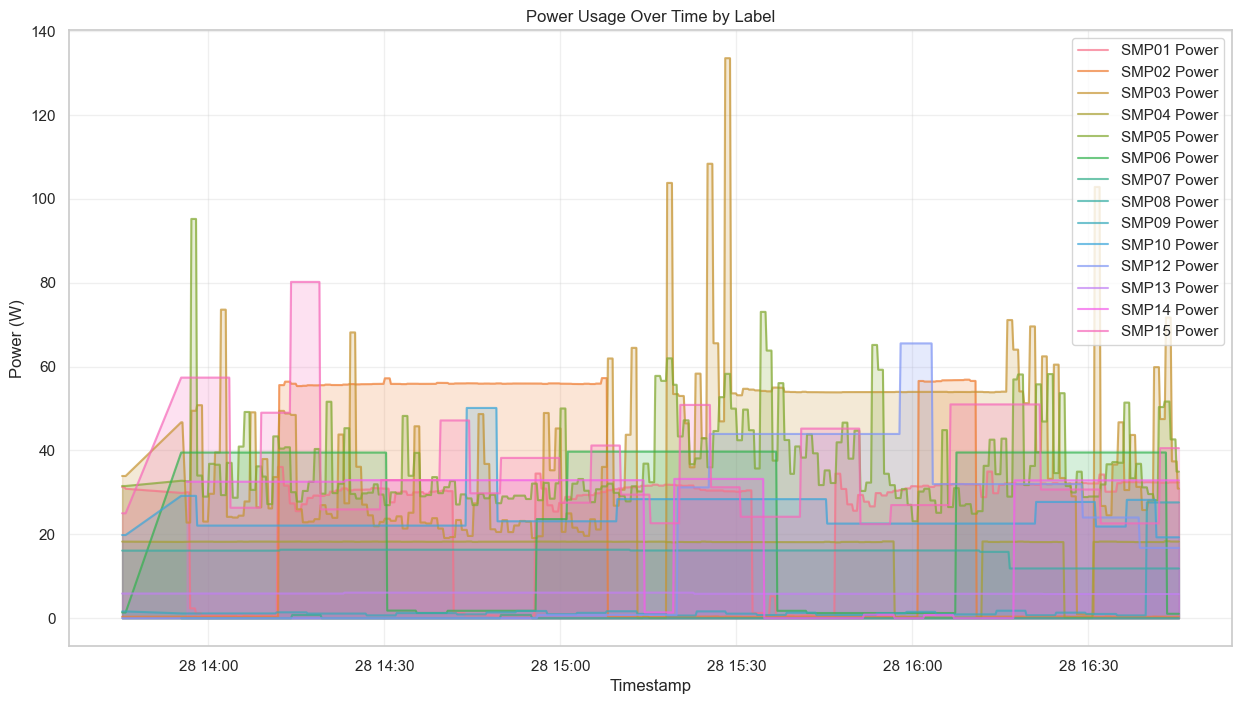

Saved combined graph: C:\Users\lime9\PycharmProjects\semanticProject\visualization\combined_power_usage.png


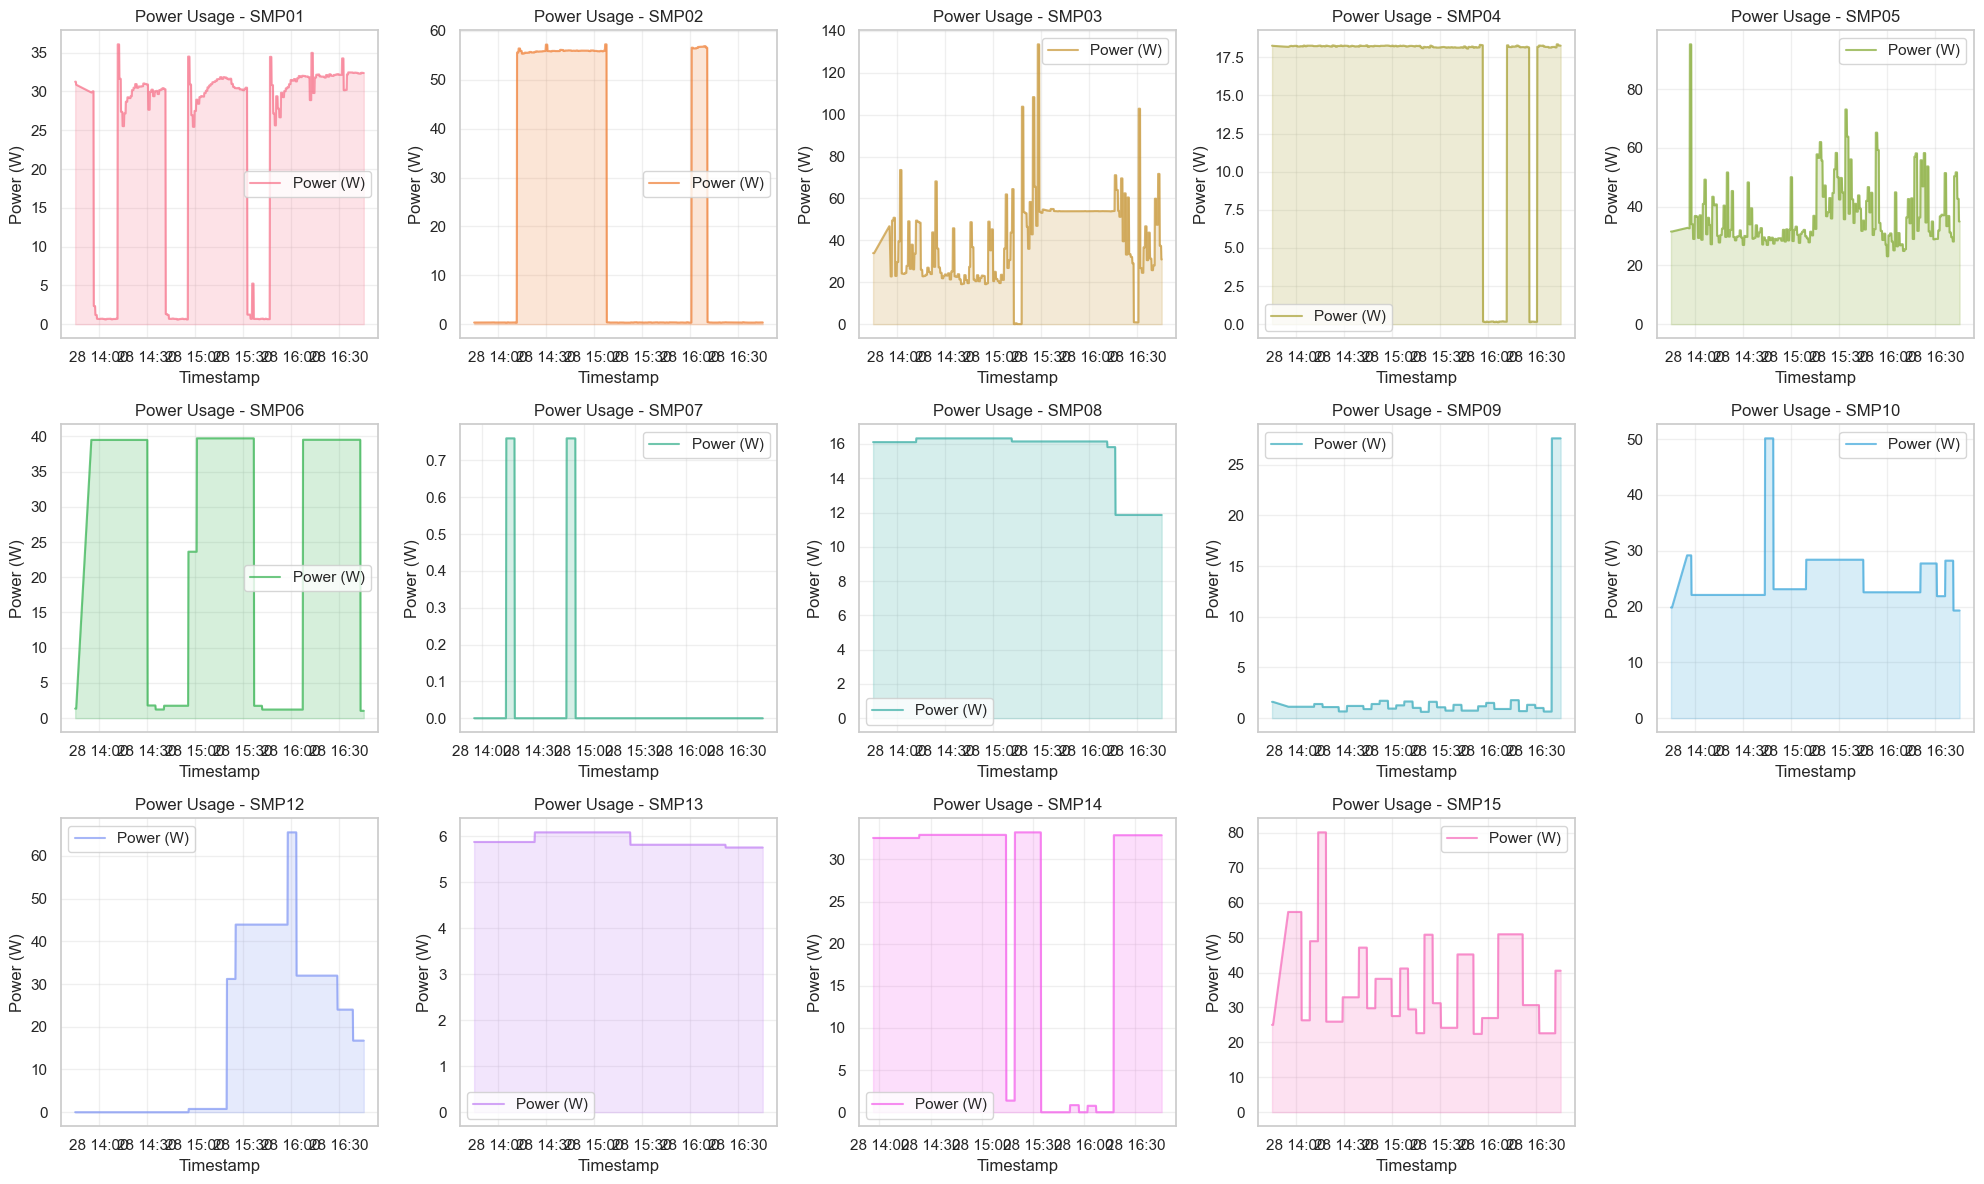

Saved graph: C:\Users\lime9\PycharmProjects\semanticProject\visualization\SMP01_xtime_ypower.png
Saved graph: C:\Users\lime9\PycharmProjects\semanticProject\visualization\SMP02_xtime_ypower.png
Saved graph: C:\Users\lime9\PycharmProjects\semanticProject\visualization\SMP03_xtime_ypower.png
Saved graph: C:\Users\lime9\PycharmProjects\semanticProject\visualization\SMP04_xtime_ypower.png
Saved graph: C:\Users\lime9\PycharmProjects\semanticProject\visualization\SMP05_xtime_ypower.png
Saved graph: C:\Users\lime9\PycharmProjects\semanticProject\visualization\SMP06_xtime_ypower.png
Saved graph: C:\Users\lime9\PycharmProjects\semanticProject\visualization\SMP07_xtime_ypower.png
Saved graph: C:\Users\lime9\PycharmProjects\semanticProject\visualization\SMP08_xtime_ypower.png
Saved graph: C:\Users\lime9\PycharmProjects\semanticProject\visualization\SMP09_xtime_ypower.png
Saved graph: C:\Users\lime9\PycharmProjects\semanticProject\visualization\SMP10_xtime_ypower.png
Saved graph: C:\Users\lime9\Py

In [30]:
save_path = r"C:\Users\lime9\PycharmProjects\semanticProject\visualization"
visualize(df, save_path)

## 4. Data Labeling and Preprocessing

In [19]:
# Test-data 2
used_appliances = ['SMP01', 'SMP02', 'SMP03', 'SMP04', 'SMP05', 'SMP12', 'SMP14']
test2_df = df[df['Label'].isin(used_appliances)]

In [20]:
test2_df.head()

,Timestamp,Label,Location Name,Power (W),Energy (Wh),Appliance
0,2024-11-28 13:45:17,SMP01,Laboratory 207,31.258,6151.003,Refrigerator(207)
1,2024-11-28 13:45:29,SMP01,Laboratory 207,31.258,6151.003,Refrigerator(207)
2,2024-11-28 13:45:41,SMP01,Laboratory 207,31.258,6151.003,Refrigerator(207)
3,2024-11-28 13:45:53,SMP01,Laboratory 207,30.866,6151.521,Refrigerator(207)
4,2024-11-28 13:55:22,SMP01,Laboratory 207,29.868,6156.029,Refrigerator(207)


In [21]:
# save the data
save_dir = r'C:\Users\lime9\PycharmProjects\semanticProject\outputs'
save_path = os.path.join(save_dir, 'dataset_collect2.csv')
test2_df.to_csv(save_path, index=False)
print(f"DataFrame saved to csv file in {save_path}")

DataFrame saved to csv file in C:\Users\lime9\PycharmProjects\semanticProject\outputs\dataset_collect2.csv


In [10]:
def label_activities(df):
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Activities mapping
    # TODO: This could be revised by your situation
    activities = {
        "nu": "Not used",
        "a": "Absence",
        "wpc": "Working with PC",
        "wopc": "Working without PC", 
        "m": "Meeting",
        "l": "Lunch",
        "gw": "Go to work",
        "gow": "Get off work"
    }
    
    # Initialize all rows as Absence
    df['Activity'] = activities['nu']
    
    # Function to convert hour and minute to time object
    def create_time(hour, minute):
        return time(hour, minute)
    
    # Convert timestamp column to time for comparison
    time_column = pd.to_datetime(df['Timestamp']).dt.time
    
    # Create boolean masks for each device group
    mask_smp03_14 = df['Label'].isin(['SMP03', 'SMP14'])
    mask_smp12 = df['Label'] == 'SMP12'
    mask_smp04_05 = df['Label'].isin(['SMP04', 'SMP05'])
    mask_smp01 = df['Label'] == 'SMP01'
    mask_smp02 = df['Label'] == 'SMP02'
    
    # Dictionary of time periods and activities for each device group
    # TODO: multi-user?
    time_periods = {
        # HW monitor and computer
        'SMP03_14': [
            ((create_time(15,17), create_time(15,30)), activities['wpc']),
            ((create_time(15,30), create_time(16,0)), activities['wopc']),
            ((create_time(16,16), create_time(16,27)), activities['wpc'])
        ],
        # YR battery
        'SMP12': [
            ((create_time(15,20), create_time(15,35)), activities['wpc']),
            ((create_time(15,37), create_time(16,0)), activities['wpc']),
            ((create_time(16,10), create_time(16,25)), activities['wopc'])
        ],
        # JI monitor and computer
        'SMP04_05': [
            ((create_time(15,15), create_time(15,50)), activities['wpc']),
            ((create_time(15,52), create_time(15,55)), activities['wpc']),
            ((create_time(15,52), create_time(16,0)), activities['wopc']),
            ((create_time(16,10), create_time(16,25)), activities['wpc'])
        ],
        # Refrigerator
        'SMP01': [
            ((create_time(15,35), create_time(15,37)), activities['l']),
            ((create_time(15,50), create_time(15,52)), activities['l']),
            ((create_time(16,10), create_time(16,12)), activities['l'])
        ],
        # Projector
        'SMP02': [
            ((create_time(16,00), create_time(16,10)), activities['m'])
        ]
    }
    
    # Apply time periods for each device group
    for (start_time, end_time), activity in time_periods['SMP03_14']:
        mask = mask_smp03_14 & time_column.between(start_time, end_time)
        df.loc[mask, 'Activity'] = activity
        
    for (start_time, end_time), activity in time_periods['SMP12']:
        mask = mask_smp12 & time_column.between(start_time, end_time)
        df.loc[mask, 'Activity'] = activity
        
    for (start_time, end_time), activity in time_periods['SMP04_05']:
        mask = mask_smp04_05 & time_column.between(start_time, end_time)
        df.loc[mask, 'Activity'] = activity
    
    for (start_time, end_time), activity in time_periods['SMP01']:
        mask = mask_smp01 & time_column.between(start_time, end_time)
        df.loc[mask, 'Activity'] = activity
        
    for (start_time, end_time), activity in time_periods['SMP02']:
        mask = mask_smp02 & time_column.between(start_time, end_time)
        df.loc[mask, 'Activity'] = activity
    
    # Label specific times for go to work and get off work
    go_to_work = {
        'SMP03_14': (create_time(15,17), create_time(15,18)),
        'SMP12': (create_time(15,20), create_time(15,21))
    }
    
    get_off_work = {
        'SMP03_14': (create_time(16,27), create_time(16,28)),
        'SMP12': (create_time(16,25), create_time(16,26)),
        'SMP04_05': (create_time(16,25), create_time(16,26))
    }
    
    # Apply go to work and get off work times
    for device, (start_time, end_time) in go_to_work.items():
        if device == 'SMP03_14':
            mask = mask_smp03_14 & time_column.between(start_time, end_time)
        else:
            mask = mask_smp12 & time_column.between(start_time, end_time)
        df.loc[mask, 'Activity'] = activities['gw']
    
    for device, (start_time, end_time) in get_off_work.items():
        if device == 'SMP03_14':
            mask = mask_smp03_14 & time_column.between(start_time, end_time)
        elif device == 'SMP12':
            mask = mask_smp12 & time_column.between(start_time, end_time)
        else:
            mask = mask_smp04_05 & time_column.between(start_time, end_time)
        df.loc[mask, 'Activity'] = activities['gow']
    
    return df


In [22]:
act_df = label_activities(test2_df)
act_df.head()

,Timestamp,Label,Location Name,Power (W),Energy (Wh),Appliance,Activity
0,2024-11-28 13:45:17,SMP01,Laboratory 207,31.258,6151.003,Refrigerator(207),Not used
1,2024-11-28 13:45:29,SMP01,Laboratory 207,31.258,6151.003,Refrigerator(207),Not used
2,2024-11-28 13:45:41,SMP01,Laboratory 207,31.258,6151.003,Refrigerator(207),Not used
3,2024-11-28 13:45:53,SMP01,Laboratory 207,30.866,6151.521,Refrigerator(207),Not used
4,2024-11-28 13:55:22,SMP01,Laboratory 207,29.868,6156.029,Refrigerator(207),Not used


In [23]:
# save the data
save_dir = r'C:\Users\lime9\PycharmProjects\semanticProject\outputs'
save_path = os.path.join(save_dir, 'dataset_activity.csv')
act_df.to_csv(save_path, index=False)
print(f"DataFrame saved to csv file in {save_path}")

DataFrame saved to csv file in C:\Users\lime9\PycharmProjects\semanticProject\outputs\dataset_activity.csv


In [49]:
def plot_activity_distribution(df):
    # Set seaborn style
    sns.set_theme(style="whitegrid")
    
    # Count the activities
    activity_counts = df['Activity'].value_counts()
    
    # Create figure with larger size
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create pie chart with labels outside
    patches, texts, autotexts = ax.pie(activity_counts,
                                     labels=activity_counts.index,
                                     autopct='%1.1f%%',
                                     pctdistance=0.75,
                                     labeldistance=1.2,  # Move labels outside
                                     colors=sns.color_palette("husl", n_colors=len(activity_counts)))
    
    # Add count values to percentage labels
    for i, autotext in enumerate(autotexts):
        count = activity_counts.iloc[i]
        autotext.set_text(f'{count:,d}\n({autotext.get_text()})')
    
    # Ensure text doesn't overlap with the chart
    plt.title('Activity Distribution', pad=20)
    
    # Add legend
    plt.legend(patches,
              activity_counts.index,
              title="Activities",
              loc="upper left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    
    # Adjust layout to prevent text cutoff
    plt.tight_layout()
    
    return plt

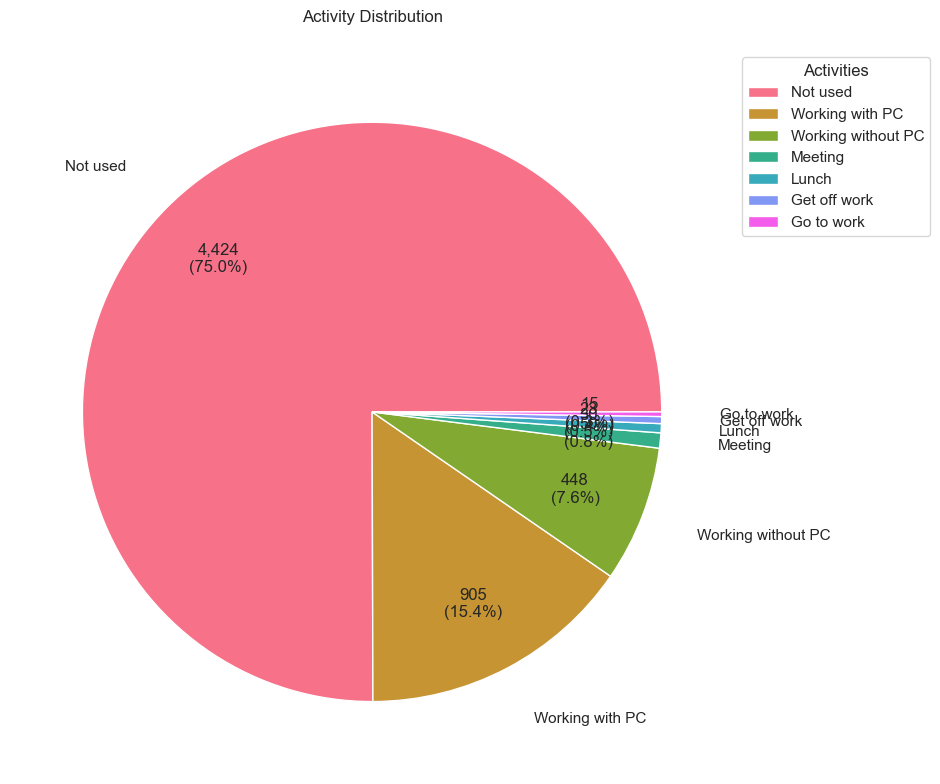

In [50]:
plot_activity_distribution(act_df)
plt.show()

In [52]:
activity_counts = act_df['Activity'].value_counts()
activity_counts

Not used              4424
Working with PC        905
Working without PC     448
Meeting                 50
Lunch                   30
Get off work            23
Go to work              15
Name: Activity, dtype: int64

In [54]:
df

,Timestamp,Label,Location Name,Power (W),Energy (Wh),Appliance
0,2024-11-28 13:45:17,SMP01,Laboratory 207,31.258,6151.003,Refrigerator(207)
1,2024-11-28 13:45:29,SMP01,Laboratory 207,31.258,6151.003,Refrigerator(207)
2,2024-11-28 13:45:41,SMP01,Laboratory 207,31.258,6151.003,Refrigerator(207)
3,2024-11-28 13:45:53,SMP01,Laboratory 207,30.866,6151.521,Refrigerator(207)
4,2024-11-28 13:55:22,SMP01,Laboratory 207,29.868,6156.029,Refrigerator(207)
...,...,...,...,...,...,...
11787,2024-11-28 16:44:39,SMP15,Laboratory 205,40.550,12.012,Giup Computer
11788,2024-11-28 16:44:51,SMP15,Laboratory 205,40.550,12.012,Giup Computer
11789,2024-11-28 16:45:03,SMP15,Laboratory 205,40.550,12.012,Giup Computer
11790,2024-11-28 16:45:15,SMP15,Laboratory 205,40.550,12.012,Giup Computer


In [13]:
aggregated_df = df.groupby("Timestamp")["Power (W)"].sum().reset_index()
aggregated_df.rename(columns={"Power (W)": "Total Power (W)"}, inplace=True)
aggregated_df

,Timestamp,Total Power (W)
0,2024-11-28 13:45:17,185.098
1,2024-11-28 13:45:29,185.098
2,2024-11-28 13:45:41,185.098
3,2024-11-28 13:45:53,184.697
4,2024-11-28 13:55:21,247.192
...,...,...
886,2024-11-28 16:44:39,286.816
887,2024-11-28 16:44:51,286.794
888,2024-11-28 16:45:03,279.117
889,2024-11-28 16:45:15,272.622


In [14]:
act_df = act_df.merge(aggregated_df, on="Timestamp", how="left")
act_df

,Timestamp,Label,Location Name,Power (W),Energy (Wh),Appliance,Activity,Total Power (W)
0,2024-11-28 13:45:17,SMP01,Laboratory 207,31.258,6151.003,Refrigerator(207),Not used,185.098
1,2024-11-28 13:45:29,SMP01,Laboratory 207,31.258,6151.003,Refrigerator(207),Not used,185.098
2,2024-11-28 13:45:41,SMP01,Laboratory 207,31.258,6151.003,Refrigerator(207),Not used,185.098
3,2024-11-28 13:45:53,SMP01,Laboratory 207,30.866,6151.521,Refrigerator(207),Not used,184.697
4,2024-11-28 13:55:22,SMP01,Laboratory 207,29.868,6156.029,Refrigerator(207),Not used,29.868
...,...,...,...,...,...,...,...,...
5890,2024-11-28 16:44:39,SMP14,Laboratory 207,32.870,0.208,Haewon Monitor,Not used,286.816
5891,2024-11-28 16:44:51,SMP14,Laboratory 207,32.870,0.208,Haewon Monitor,Not used,286.794
5892,2024-11-28 16:45:03,SMP14,Laboratory 207,32.870,0.208,Haewon Monitor,Not used,279.117
5893,2024-11-28 16:45:15,SMP14,Laboratory 207,32.870,0.208,Haewon Monitor,Not used,272.622


In [15]:
# save the data
save_dir = r'C:\Users\lime9\PycharmProjects\semanticProject\outputs'
save_path = os.path.join(save_dir, 'dataset_aggregated.csv')
act_df.to_csv(save_path, index=False)
print(f"DataFrame saved to csv file in {save_path}")

DataFrame saved to csv file in C:\Users\lime9\PycharmProjects\semanticProject\outputs\dataset_aggregated.csv


In [16]:
df = act_df.copy()

# Preprocessing
label_encoder = LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Label"])
df["Location Name"] = label_encoder.fit_transform(df["Location Name"])
df["Appliance"] = label_encoder.fit_transform(df["Appliance"])
df["Activity"] = label_encoder.fit_transform(df["Activity"])  # Target

# Convert Timestamp to Unix time
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Unix Time"] = (df["Timestamp"].astype('int64') // 10**9)

# Normalize numerical columns
scaler = StandardScaler()
numerical_cols = ["Power (W)", "Energy (Wh)", "Total Power (W)", "Unix Time"]
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Prepare train-test
X = df.drop(columns=["Activity", "Timestamp"])  # Features
y = df["Activity"]  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

df

,Timestamp,Label,Location Name,Power (W),Energy (Wh),Appliance,Activity,Total Power (W),Unix Time
0,2024-11-28 13:45:17,0,1,0.281331,1.114397,5,4,-2.087065,-1.928474
1,2024-11-28 13:45:29,0,1,0.281331,1.114397,5,4,-2.087065,-1.924413
2,2024-11-28 13:45:41,0,1,0.281331,1.114397,5,4,-2.087065,-1.920353
3,2024-11-28 13:45:53,0,1,0.260976,1.114573,5,4,-2.095251,-1.916292
4,2024-11-28 13:55:22,0,1,0.209152,1.116103,5,4,-5.256035,-1.723759
...,...,...,...,...,...,...,...,...,...
5890,2024-11-28 16:44:39,6,1,0.365037,-0.973305,1,4,-0.010525,1.713083
5891,2024-11-28 16:44:51,6,1,0.365037,-0.973305,1,4,-0.010974,1.717144
5892,2024-11-28 16:45:03,6,1,0.365037,-0.973305,1,4,-0.167697,1.721204
5893,2024-11-28 16:45:15,6,1,0.365037,-0.973305,1,4,-0.300291,1.725265


In [17]:
# save the data
save_dir = r'C:\Users\lime9\PycharmProjects\semanticProject\outputs'
save_path = os.path.join(save_dir, 'dataset_aggregated_normalize.csv')
df.to_csv(save_path, index=False)
print(f"DataFrame saved to csv file in {save_path}")

DataFrame saved to csv file in C:\Users\lime9\PycharmProjects\semanticProject\outputs\dataset_aggregated_normalize.csv


In [154]:
df['Label'].value_counts()

0    843
1    843
2    843
3    843
4    843
5    843
6    837
Name: Label, dtype: int64

## 5. Model Structure

In [141]:
# TODO: config에 넣기
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [135]:
class FullSemanticRelativeEntropyLoss(nn.Module):
    def __init__(self, epsilon=1e-8):
        """
        Custom Semantic Relative Entropy Loss.
        
        Args:
        - epsilon (float): Small value to prevent division by zero.
        """
        super(FullSemanticRelativeEntropyLoss, self).__init__()
        self.epsilon = epsilon
    
    def forward(self, p_logits, q_logits, group_indices):
        """
        Compute Semantic Relative Entropy Loss.
        
        Args:
        - p_logits (torch.Tensor): Predicted logits (shape: [batch_size, num_classes]).
        - q_logits (torch.Tensor): Target logits (shape: [batch_size, num_classes]).
        - group_indices (list of lists): Each sublist contains indices for the groups.
        
        Returns:
        - torch.Tensor: Loss value.
        """
        # Convert logits to probabilities using softmax
        p_probs = torch.softmax(p_logits, dim=1)
        q_probs = torch.softmax(q_logits, dim=1)
        
        loss = 0.0
        for group in group_indices:
            # Sum probabilities within the group
            p_group_sum = torch.sum(p_probs[:, group], dim=1)
            q_group_sum = torch.sum(q_probs[:, group], dim=1)

            # Calculate the ratio and avoid log(0)
            ratio = (p_group_sum + self.epsilon) / (q_group_sum + self.epsilon)

            # Compute group entropy contribution
            group_entropy = torch.sum(p_group_sum * torch.log(ratio))
            loss += group_entropy

        return loss / len(group_indices)  # Normalize by number of groups


class TruePartialSemanticRelativeEntropyLoss(nn.Module):
    def __init__(self):
        super(TruePartialSemanticRelativeEntropyLoss, self).__init__()
    
    def forward(self, p, q, groups):
        loss = 0.0
        
        for group in groups:
            # Select the probabilities corresponding to the current group
            p_group = p[group]
            q_group = q[group]
            
            # Compute group-wise sums
            p_sum = torch.sum(p_group)
            
            epsilon = 1e-8
            
            # Compute the group contribution to loss(entropy)
            ratio = (p_sum + epsilon) / (q_group + epsilon)
            group_entropy = torch.sum(p_group * torch.log(ratio))
            loss += group_entropy
        
        return loss
    

class PredictPartialSemanticRelativeEntropyLoss(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(PredictPartialSemanticRelativeEntropyLoss, self).__init__()
        self.epsilon = epsilon
        
    def forward(self, p, q, groups):
        loss = 0.0
        
        for group in groups:
            # Select the probabilities corresponding to the current group
            p_group = p[group]
            q_group = q[group]
            
            # Compute group-wise sums
            q_sum = torch.sum(q_group)
            
            epsilon = 1e-8
            
            # Compute the group contribution to loss(entropy)
            ratio = (p_group + epsilon) / (q_sum + epsilon)
            group_entropy = torch.sum(p_group * torch.log(ratio))
            loss += group_entropy
        
        return loss

In [132]:
# TODO: this is simple version
class SemanticNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(SemanticNetwork, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.output_layer = nn.Linear(64, output_size)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        output = self.output_layer(decoded)
        return output
    

In [131]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([4716, 7])
X_test shape: torch.Size([1179, 7])
y_train shape: torch.Size([4716])
y_test shape: torch.Size([1179])


In [136]:
# Model configuration
input_size = X_train.shape[1]
output_size = len(y_train.unique())  # Number of classes
model = SemanticNetwork(input_size, output_size)

print("input size:", input_size)
print("output size:", output_size)
print(model)

input size: 7
output size: 7
SemanticNetwork(
  (encoder): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
  )
  (output_layer): Linear(in_features=64, out_features=7, bias=True)
)


In [147]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2
batch_size = 4

# Training
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for i in range(0, X_train.shape[0], batch_size):
        # Get batch data
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        
        # Forward pass
        print('X_batch:\n', X_batch)
        print('y_batch:\n', y_batch)
        outputs = model(X_batch)
        print('outputs:\n', outputs)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

X_batch:
 tensor([[ 5.0000,  1.0000,  0.9394, -0.9733,  6.0000,  1.4683,  0.1265],
        [ 4.0000,  1.0000,  0.4416,  1.8378,  2.0000,  0.4029,  1.1071],
        [ 1.0000,  1.0000, -1.3225, -0.6760,  4.0000,  1.2248, -1.6767],
        [ 6.0000,  0.0000,  0.3479, -0.9733,  1.0000, -0.8454, -1.6398]])
y_batch:
 tensor([5, 5, 4, 4])
tensor([[ -68.6757,    9.9937,   -3.1127,  -80.0933,    0.6963,   13.4870,
          -76.7462],
        [  -1.1202,   -8.7988,  -14.3148,  -19.8751,    2.2873,    8.5097,
          -25.2435],
        [-303.4336,  -81.0998,   33.1547, -220.8909,  124.0340,  -80.4841,
         -401.9830],
        [-231.4437,  -78.7506,   27.4614, -154.8172,   94.2574,  -65.6222,
         -312.1766]], grad_fn=<AddmmBackward0>)
X_batch:
 tensor([[ 4.0000,  1.0000,  0.2950,  1.8408,  2.0000, -0.1931,  1.3375],
        [ 1.0000,  1.0000, -1.3244, -0.6551,  4.0000,  0.5716,  1.1521],
        [ 3.0000,  1.0000, -0.4029, -0.1972,  3.0000, -0.0605,  0.5528],
        [ 3.0000,  1.0000,

In [140]:
# Evaluation
model.eval()
with torch.no_grad():
    # Forward pass for test data
    y_pred_logits = model(X_test)
    y_pred_classes = torch.argmax(y_pred_logits, dim=1)

    # Compute accuracy
    accuracy = accuracy_score(y_test.cpu(), y_pred_classes.cpu())
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9763
